<a href="https://colab.research.google.com/drive/10jmbpP0xcbJXsmWvy2yvI4v04Y4v65Tp?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Построение вопросно-ответной системы с использованием RAG

### импорты

In [75]:
%pip install -r requeirements.txt

In [7]:
from IPython.display import clear_output
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import re


import nltk
from nltk.tokenize import sent_tokenize
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
from collections import defaultdict
from collections import  Counter

from sklearn.feature_extraction.text import CountVectorizer
import wordcloud
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS

import gensim
from gensim.models import Word2Vec
from nltk import FreqDist
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


### загрузка датасета

In [2]:
# загрузка csv файла из google drive
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1dgnwG1AZhspMJaDR6jz828qZkSnZg25t' -O full_dataset.csv

--2024-11-03 07:07:15--  https://docs.google.com/uc?export=download&id=1dgnwG1AZhspMJaDR6jz828qZkSnZg25t
Resolving docs.google.com (docs.google.com)... 108.177.11.139, 108.177.11.138, 108.177.11.101, ...
Connecting to docs.google.com (docs.google.com)|108.177.11.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1dgnwG1AZhspMJaDR6jz828qZkSnZg25t&export=download [following]
--2024-11-03 07:07:15--  https://drive.usercontent.google.com/download?id=1dgnwG1AZhspMJaDR6jz828qZkSnZg25t&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.134.132, 2607:f8b0:400c:c00::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.134.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45451452 (43M) [application/octet-stream]
Saving to: ‘full_dataset.csv’

full_dataset.csv    100%[===================>]  43.35M  88.4MB/s   

In [3]:
rag_dataset = pd.read_csv('full_dataset.csv')
rag_dataset

,context,question,answer
0,Caption: Tasmanian berry grower Nic Hansen sho...,What is the Berry Export Summary 2028 and what...,The Berry Export Summary 2028 is a dedicated e...
1,RWSN Collaborations\nSouthern Africa Self-supp...,What are some of the benefits reported from ha...,Benefits reported from having access to Self-s...
2,All Android applications categories\nDescripti...,What are the unique features of the Coolands f...,The unique features of the Coolands for Twitte...
3,"How unequal is India? The question is simple, ...",What is the main difference between the Nation...,The main difference between the NSS and the IH...
4,Gunnar Nelson took his time on the feet agains...,How did Gunnar Nelson win the fight against Za...,Gunnar Nelson won the fight against Zak Cummin...
...,...,...,...
11995,"Fuzzy's Ultra Premium Vodka\nThe Myth, The Man...",What are some of the achievements of Fuzzy Zoe...,Fuzzy Zoeller is known for his golfing success...
11996,Swedish Grand Prix rider Malin Nilsson got mar...,Who did Malin Nilsson marry on 2 June 2018?,"Malin Nilsson got married to her partner, Germ..."
11997,The Cracchiolo Law Library of the James E. Rog...,What is the Fellowship in Law Librarianship of...,The Fellowship in Law Librarianship is a progr...
11998,2nd physical eMAG store opens in Mammut\nOnlin...,Where has the second physical eMAG store been ...,The second physical eMAG store has been opened...


In [79]:
# вывод одного сэмпла
rag_dataset.values[0]

array(['Caption: Tasmanian berry grower Nic Hansen showing Macau chef Antimo Merone around his property as part of export engagement activities.\nTHE RISE and rise of the Australian strawberry, raspberry and blackberry industries has seen the sectors redouble their international trade focus, with the release of a dedicated export plan to grow their global presence over the next 10 years.\nDriven by significant grower input, the Berry Export Summary 2028 maps the sectors’ current position, where they want to be, high-opportunity markets and next steps.\nHort Innovation trade manager Jenny Van de Meeberg said the value and volume of raspberry and blackberry exports rose by 100 per cent between 2016 and 2017. She said the Australian strawberry industry experienced similar success with an almost 30 per cent rise in export volume and a 26 per cent rise in value to $32.6M over the same period.\n“Australian berry sectors are in a firm position at the moment,” she said. “Production, adoption o

Видны посторонние символы, такие как перевод строки \n

Имеется 3 колонки и 12000 строк

In [8]:
rag_dataset['question'][0]

'What is the Berry Export Summary 2028 and what is its purpose?'

In [81]:
rag_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   context   12000 non-null  object
 1   question  11997 non-null  object
 2   answer    11997 non-null  object
dtypes: object(3)
memory usage: 281.4+ KB


In [9]:
# пустые значение
rag_dataset[rag_dataset['question'].isnull()]

,context,question,answer
340,.\nThe. Give people.\nHome Office. (2002). A g...,NaN,NaN
2818,come back ! for Budcome back ! for Bud\nthe st...,NaN,NaN
11746,"Flood,\nDefinition of Flood:\n-\nArrive in lar...",NaN,NaN


### EDA

In [10]:
df = rag_dataset.copy()

df.columns

Index(['context', 'question', 'answer'], dtype='object')

In [11]:
# проверка на полные дубликаты
df[df.duplicated()]

,context,question,answer


In [12]:
# проверка на дубликаты в колонке context
df[df.duplicated(subset=['context'])]

,context,question,answer


In [13]:
# проверка на дубликаты в колонке question
df[df.duplicated(subset=['question'], keep=False)].sort_values('question')

,context,question,answer
9991,Background – Nectar Mattress Review – Is This ...,What are some of the features that set the Nec...,Some of the features that set the Nectar mattr...
6225,Background – Nectar Mattress Review – Is This ...,What are some of the features that set the Nec...,The Nectar mattress is a reasonably priced foa...
9259,Explore Concrete Pump Operator careers and fin...,What are some of the job roles mentioned in th...,Some of the job roles mentioned in the context...
9070,lead teacher jobs\nTeacher - Early ChildhoodNE...,What are some of the job roles mentioned in th...,Some of the job roles mentioned in the context...
11587,"I'm sorry the pictures are so dark.....""someon...",What are the ingredients needed for the recipe...,The ingredients needed for the recipe are .5 C...
2599,Description\nIf I eat flour I prefer to eat ry...,What are the ingredients needed for the recipe...,The ingredients needed for the recipe are Rye ...
10753,Hose hook up for jet skiChameleon dating sites...,What is the context about?,"The context is about various topics, including..."
8322,"""they are both comparatively late age, on n'a ...",What is the context about?,The context is a collection of various sentenc...
11483,order by popularity | order by alphabet\nLike ...,What is the context about?,The context is about a list of titles or phras...
6217,The synthetic fragrant compounds based on 2-te...,What is the context about?,The context is about synthetic fragrant compou...


Видим, что есть повторяющиеся вопросы, но это скорее вопросы общего характера, могут быть использованы к разным контекстам, возможно нужно будет в будущем избавиться от таких строк, так как вопросы одинаковые, при этом контексты отличаются по наполнению, ответы разные. То, что вопросы одинаковые - ответы разные, может повлиять на работу модели в будущем.

Также обнаружены несколько строк с NaN

In [14]:
# проверка на дубликаты в колонке answer
df[df.duplicated(subset=['answer'])]

,context,question,answer
2818,come back ! for Budcome back ! for Bud\nthe st...,NaN,NaN
11746,"Flood,\nDefinition of Flood:\n-\nArrive in lar...",NaN,NaN


In [15]:
# удаление строк с пустыми значениями (None)
df = df.dropna()

In [16]:
df['context'][0]

'Caption: Tasmanian berry grower Nic Hansen showing Macau chef Antimo Merone around his property as part of export engagement activities.\nTHE RISE and rise of the Australian strawberry, raspberry and blackberry industries has seen the sectors redouble their international trade focus, with the release of a dedicated export plan to grow their global presence over the next 10 years.\nDriven by significant grower input, the Berry Export Summary 2028 maps the sectors’ current position, where they want to be, high-opportunity markets and next steps.\nHort Innovation trade manager Jenny Van de Meeberg said the value and volume of raspberry and blackberry exports rose by 100 per cent between 2016 and 2017. She said the Australian strawberry industry experienced similar success with an almost 30 per cent rise in export volume and a 26 per cent rise in value to $32.6M over the same period.\n“Australian berry sectors are in a firm position at the moment,” she said. “Production, adoption of prote

In [17]:
# удаление/замена на пробел знака перевода строки в колонке 'context'
df['context'] = df['context'].apply(lambda x: x.replace('\n', ' '))
df

,context,question,answer
0,Caption: Tasmanian berry grower Nic Hansen sho...,What is the Berry Export Summary 2028 and what...,The Berry Export Summary 2028 is a dedicated e...
1,RWSN Collaborations Southern Africa Self-suppl...,What are some of the benefits reported from ha...,Benefits reported from having access to Self-s...
2,All Android applications categories Descriptio...,What are the unique features of the Coolands f...,The unique features of the Coolands for Twitte...
3,"How unequal is India? The question is simple, ...",What is the main difference between the Nation...,The main difference between the NSS and the IH...
4,Gunnar Nelson took his time on the feet agains...,How did Gunnar Nelson win the fight against Za...,Gunnar Nelson won the fight against Zak Cummin...
...,...,...,...
11995,"Fuzzy's Ultra Premium Vodka The Myth, The Man,...",What are some of the achievements of Fuzzy Zoe...,Fuzzy Zoeller is known for his golfing success...
11996,Swedish Grand Prix rider Malin Nilsson got mar...,Who did Malin Nilsson marry on 2 June 2018?,"Malin Nilsson got married to her partner, Germ..."
11997,The Cracchiolo Law Library of the James E. Rog...,What is the Fellowship in Law Librarianship of...,The Fellowship in Law Librarianship is a progr...
11998,2nd physical eMAG store opens in Mammut Online...,Where has the second physical eMAG store been ...,The second physical eMAG store has been opened...


#### Length of texts (histogram)


* sentence length analysis
* average word length analysis

In [18]:
# посмотрим на длины текстов по символам и по словам

# context
df['length__context_word'] = df.context.astype('str').apply(lambda text : len(text.split()))
df['length_contex_symbol'] = df.context.astype('str').apply(len)

# question
df['length__question_word'] = df.question.astype('str').apply(lambda text : len(text.split()))
df['length_question_symbol'] = df.question.astype('str').apply(len)

# answer
df['length__answer_word'] = df.answer.astype('str').apply(lambda text : len(text.split()))
df['length_answer_symbol'] = df.answer.astype('str').apply(len)

df.head(3)

,context,question,answer,length__context_word,length_contex_symbol,length__question_word,length_question_symbol,length__answer_word,length_answer_symbol
0,Caption: Tasmanian berry grower Nic Hansen sho...,What is the Berry Export Summary 2028 and what...,The Berry Export Summary 2028 is a dedicated e...,563,3598,12,62,50,311
1,RWSN Collaborations Southern Africa Self-suppl...,What are some of the benefits reported from ha...,Benefits reported from having access to Self-s...,713,4661,14,87,48,325
2,All Android applications categories Descriptio...,What are the unique features of the Coolands f...,The unique features of the Coolands for Twitte...,633,3844,11,61,61,406


In [24]:
# настройки для графиков
sns.set_theme(palette ='pastel', font_scale=0.8)

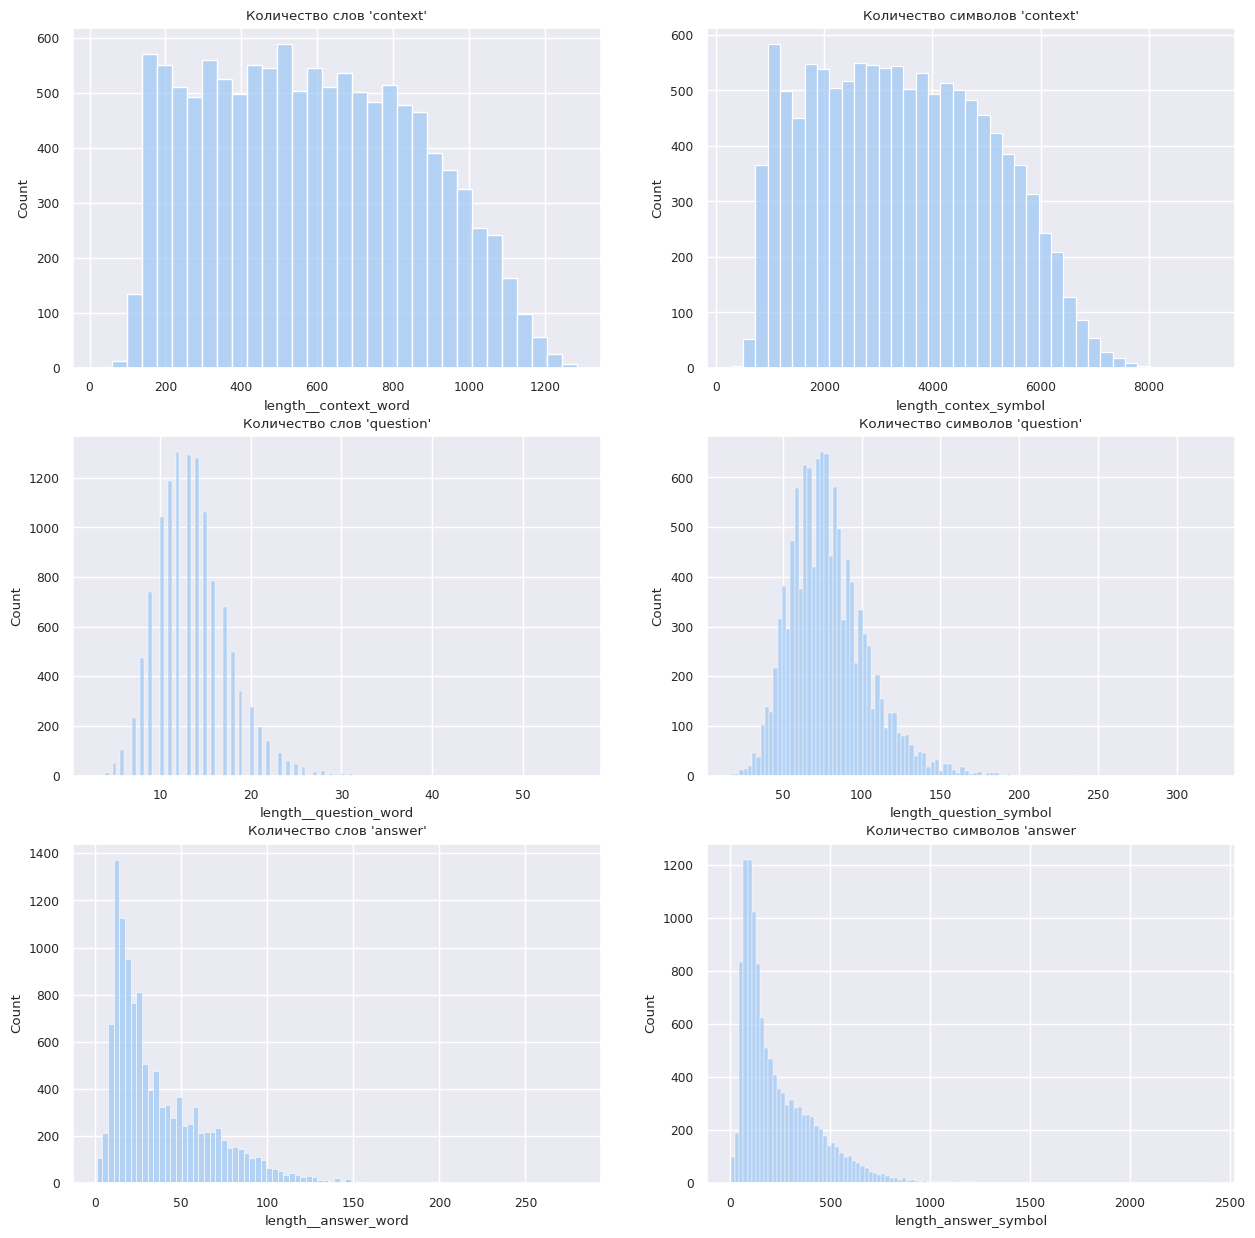

In [25]:
plt.figure(figsize = (15, 15))

plt.subplot(3, 2, 1)
sns.histplot(df["length__context_word"]).set_title("Количество слов 'context'")

plt.subplot(3, 2, 2)
sns.histplot(df["length_contex_symbol"]).set_title("Количество символов 'context'")

plt.subplot(3, 2, 3)
sns.histplot(df["length__question_word"]).set_title("Количество слов 'question'")

plt.subplot(3, 2, 4)
sns.histplot(df["length_question_symbol"]).set_title("Количество символов 'question'");

plt.subplot(3, 2, 5)
sns.histplot(df["length__answer_word"]).set_title("Количество слов 'answer'")

plt.subplot(3, 2, 6)
sns.histplot(df["length_answer_symbol"]).set_title("Количество символов 'answer");

In [26]:
df.describe(include='int64').T

,count,mean,std,min,25%,50%,75%,max
length__context_word,11997.0,581.932400,275.201171,19.0,347.0,570.0,800.0,1285.0
length_contex_symbol,11997.0,3437.894390,1612.886261,271.0,2080.0,3364.0,4698.0,9156.0
length__question_word,11997.0,13.563057,3.961316,3.0,11.0,13.0,16.0,56.0
length_question_symbol,11997.0,79.098691,24.846573,17.0,62.0,76.0,93.0,322.0
length__answer_word,11997.0,38.352005,30.098918,1.0,16.0,27.0,54.0,280.0
length_answer_symbol,11997.0,237.182796,189.504162,2.0,97.0,169.0,337.0,2408.0


Выводы:
* Самая объемная по количеству текста - слов и символов колонка context, максимальный текст в этой колонке состоит из 1285 слов, минимальный из 19.
* Привлекли внимание записи в колонке 'answer' длиной в 2 символа и в 1 слово, но после проверки, можно признать, что значение валидное (это ответ в виде двузначной цифры и коротким отрицательным словом)
* Минимальная длина текста 2 символа в колонке  'answer'
* в колонке question тексты от 3 до 56 слов


In [94]:
df.loc[df.length_answer_symbol <= 2]

,context,question,answer,length__context_word,length_contex_symbol,length__question_word,length_question_symbol,length__answer_word,length_answer_symbol
2117,Director: – Dailymotion Watch Part 1 Watch Par...,How many servers are mentioned in the context?,14,160,800,8,46,1,2
8808,Maria Henry (Nee Hardy) (born 1851) Biography ...,What was Maria Henry's maiden name?,Ne,192,1083,6,35,1,2


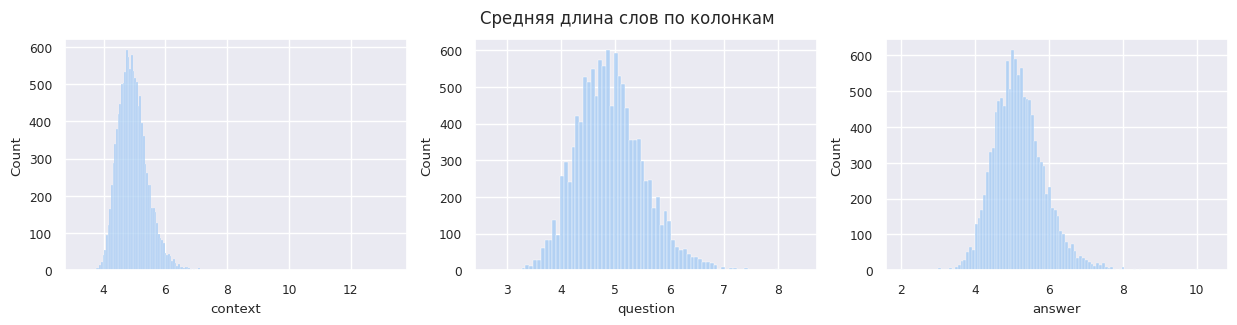

In [27]:
# Средняя длина слова  по колонкам

plt.figure(figsize = (15, 3)).suptitle('Средняя длина слов по колонкам', fontsize=12)

plt.subplot(1, 3, 1)
sns.histplot(df['context'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)));

plt.subplot(1, 3, 2)
sns.histplot(df['question'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)));

plt.subplot(1, 3, 3)
sns.histplot(df['answer'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)));

* Длина слова в 'context'  чаще всего равна 5 символам, и редко используются слова меньше, чем из 3-х символов.
* 'question' - есть довольно много слов длиной до 4 символов
* 'answer' - есть довольно много слов длиной до 4 символов, есть слова от 2-х символов

Посмотрим распределение по длинам предложений с использованием nltk.sent_tokenize

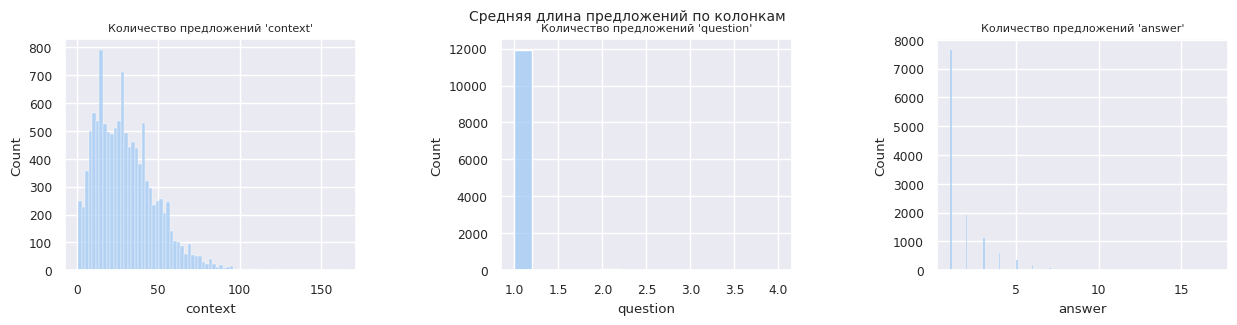

In [28]:
plt.figure(figsize = (15, 3)).suptitle('Средняя длина предложений по колонкам', fontsize=10)
plt.subplots_adjust(wspace=0.5, hspace=0.5)

plt.subplot(1, 3, 1)
sns.histplot(df.context.astype('str').apply(lambda text : len(sent_tokenize(text)))).set_title("Количество предложений 'context'", fontsize=8);

plt.subplot(1, 3, 2)
sns.histplot(df.question.astype('str').apply(lambda text : len(sent_tokenize(text)))).set_title("Количество предложений 'question'", fontsize=8);

plt.subplot(1, 3, 3)
sns.histplot(df.answer.astype('str').apply(lambda text : len(sent_tokenize(text)))).set_title("Количество предложений 'answer'", fontsize=8);

* Видно, что в основном количество предложений в поле 'context' достигает 100, небольшое количество предложений от 100 до 150. Значения довольно условное, так как sent_tokenize токенизирует неидеально.
* Вопросы 'question'состоят из одного предложения
* Ответы 'answer' в большинстве состоят из 1 предложения, есть поля до 10 предложений, но их мало.

#### Frequency


Проанализируем стоп-слова (частотность, количество) в столбце 'context'  (находить стоп-слова будем с помощью nltk.stopwords('english'))

In [29]:
# Зафиксируем список стоп-слов
STOPWORDS = set(nltk.corpus.stopwords.words('english') + ['-', '-', '–','&'])
# функция, токенизирует по словам переданный ей текст в список слов, возвращает корпус токенов
def corpus(text):
    words = text.str.split().values.tolist()
    corpus = [word.lower() for i in words for word in i]
    return corpus

In [30]:
# функция для создания столбчатой диаграммы для 15 наиболее часто встречамых стоп-слов и

def plot_top_words(text, column, stop = STOPWORDS):
    plt.figure(figsize = (15, 7)).suptitle(f'Наиболее часто встречающиеся стоп-слова и топ _НЕ_ стоп-слов {column}', fontsize=10)
    plt.subplots_adjust(wspace=0.5, hspace=0.5)

    # токенизация на слова
    corp = corpus(text)
    # создание словаря с слово : количество вхождений
    dic = defaultdict(int)
    for word in corp:
        if word in stop:
            dic[word.lower()]+=1
        #   сортировка словаря
    top = sorted(dic.items(), key=lambda x:x[1],reverse=True)[:15]
    z,w=zip(*top)
    plt.subplot(1, 2, 1)
    plt.bar(z,w)

    counter = Counter(corp)
    most = counter.most_common()


    x, y =[], []
    # отбор слов, которых нет в списке стоп-слов
    for word,count in most[:99]:
        if (word not in stop):
            x.append(word)
            y.append(count)
    plt.subplot(1, 2, 2)
    sns.barplot(x = y,y = x, hue=y)

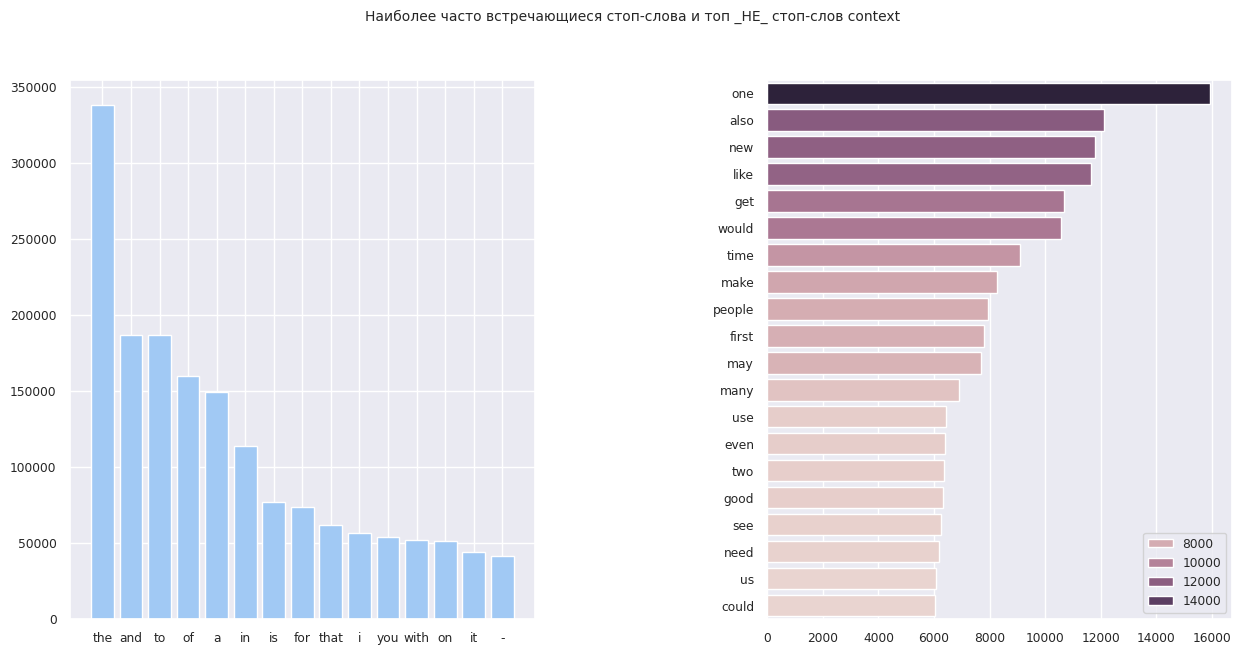

In [31]:
plot_top_words(df['context'], 'context')

context:  
наиболее частотные стоп-слова - это артикли, предлоги, тире
наиболее частот НЕ стоп-слова - числительное one, наречие also, прилагательное new, довольно обычный набор слов, свойственный повестованию

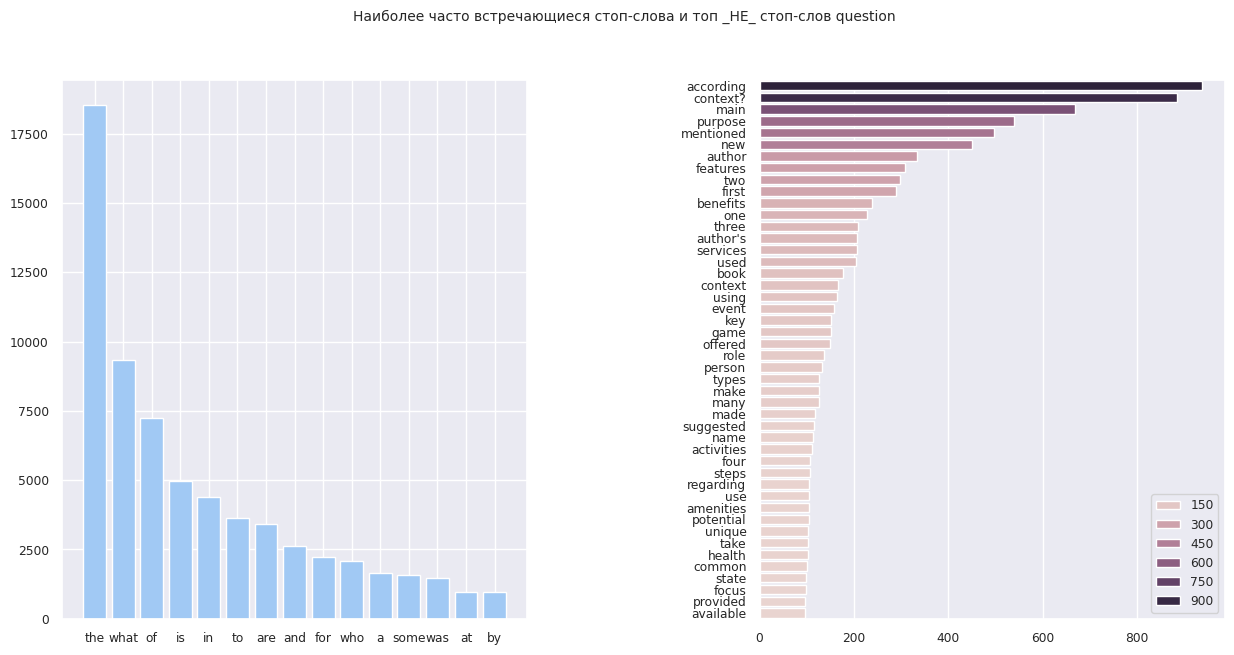

In [100]:
plot_top_words(df['question'], 'question')

question:  
наиболее частотные стоп-слова - это артикль the, вопросительное слово what, who, предлоги
наиболее частот НЕ стоп-слова - context, according, purpose, то есть некие уточняющие слова, которые могут использоваться в вопросах, в первом приближении, можно подтвердить адекватность содержимого

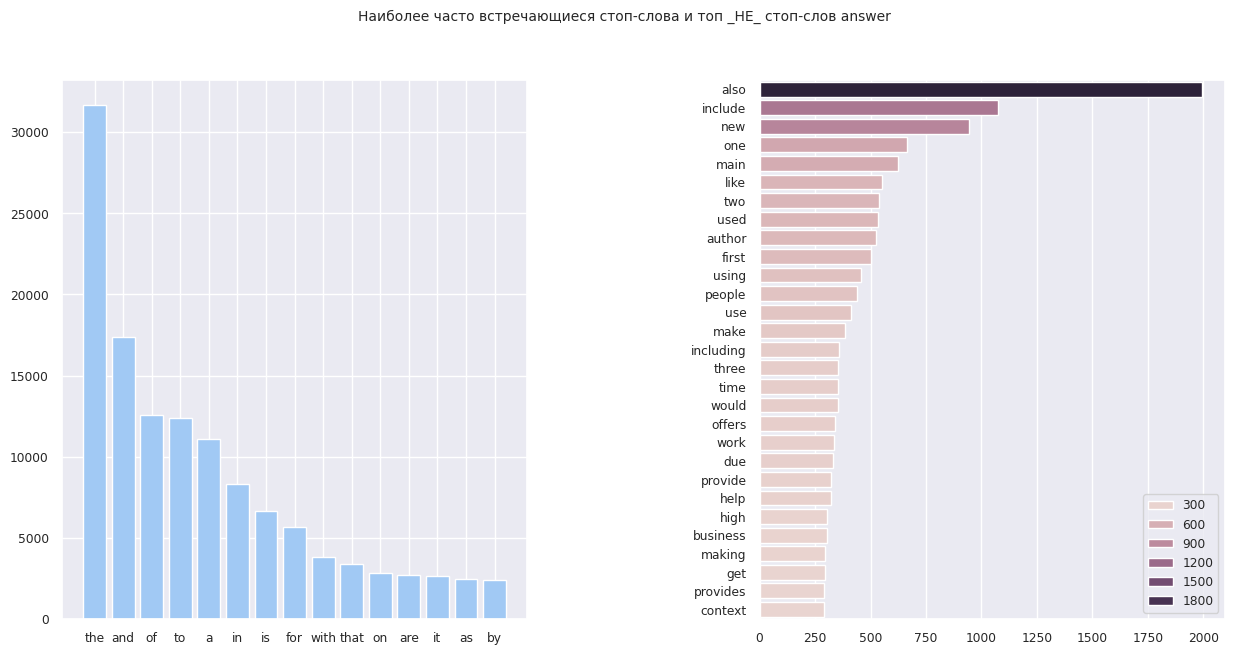

In [101]:
plot_top_words(df['answer'], 'answer')

answer:  
наиболее частотные стоп-слова - это артикль the, предлоги
наиболее частот НЕ стоп-слова - топ слов пересекается с колонкой context, например, one, new, main, like, можно предположить, что ответы связаны с контекстом, основаны на контексте

Посмотрим частотность по n-граммам

In [102]:
# функция для построения графиков частотности по n-граммам, для этого используем CountVectorizer (он выделит биграммы/триграммы)
def plot_top_ngrams(text, column, number, n=2):

    corp = corpus(text)

    def get_top_ngram(corp, n=None):
        # для извлечения  n-грамм используется CountVectorizer
        vec = CountVectorizer(ngram_range=(n, n), lowercase=True).fit(corp)
        bag_of_words = vec.transform(corp)
        sum_words = bag_of_words.sum(axis=0)
        words_freq = [(word.lower(), sum_words[0, idx])
                      for word, idx in vec.vocabulary_.items()]
        words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:10]

    top_n_bigrams = get_top_ngram(text,n)[:10]
    x,y = map(list,zip(*top_n_bigrams))
    plt.subplot(1, 3, number)
    sns.barplot(x=y,y=x, hue = y).set_title(f"{column} - {n}-граммы")

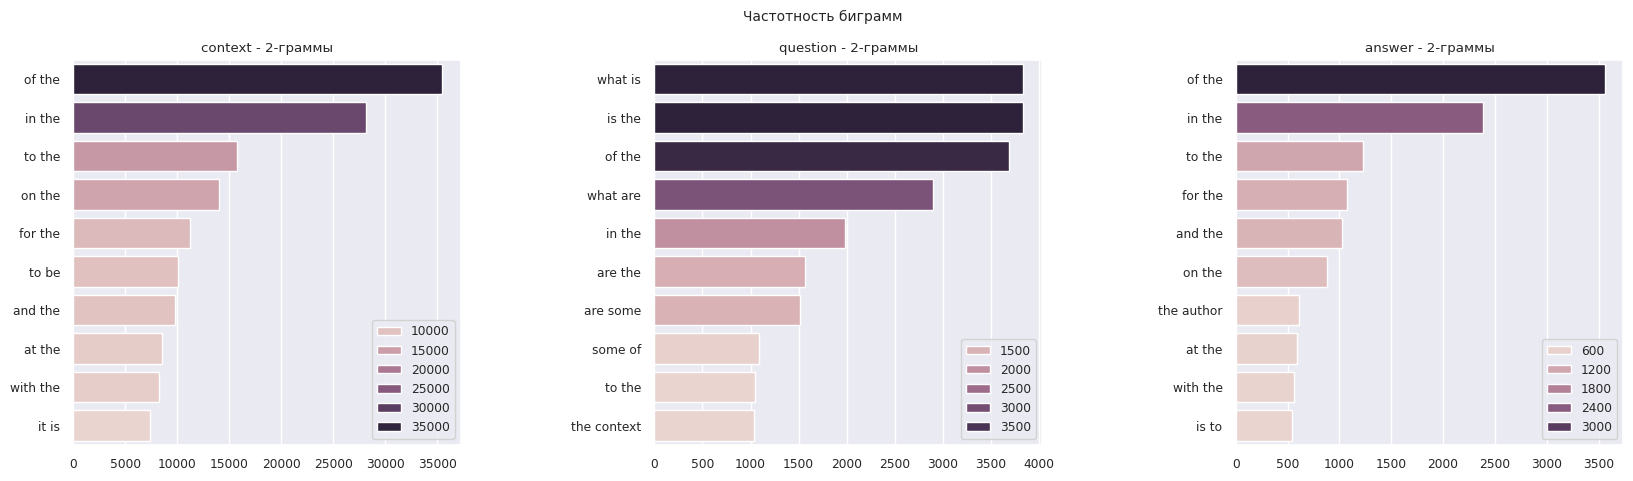

In [103]:
plt.figure(figsize = (20, 5)).suptitle('Частотность биграмм', fontsize=10)
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plot_top_ngrams(df['context'], 'context', 1, 2)
plot_top_ngrams(df['question'], 'question', 2, 2)
plot_top_ngrams(df['answer'], 'answer', 3, 2)

* Для контекста сочетания из двух слов в большинстве случаев это служебные связки, свойственные для английского языка.
* Для вопросов словосочетания - первое место вопросительное слово, также часто упоминается the context (нужно обратить внимание).
* В ответах довольно много предлогов, указывающих на место, частое упоминание the author.


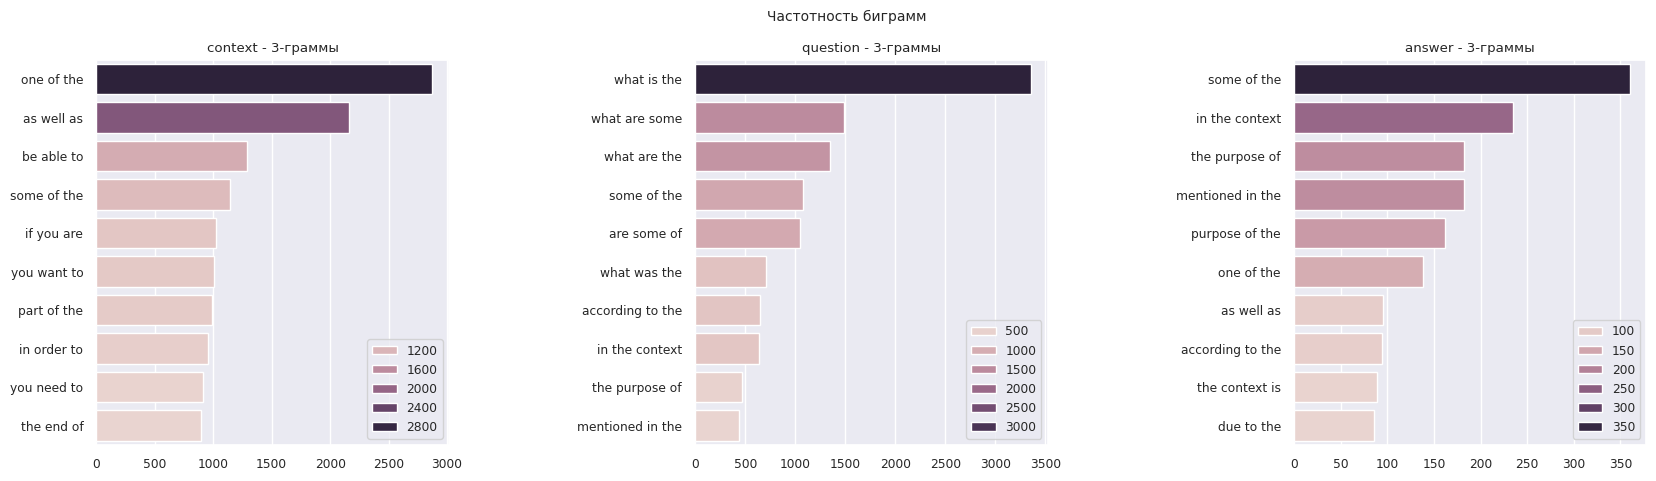

In [104]:
plt.figure(figsize = (20, 5)).suptitle('Частотность биграмм', fontsize=10)
plt.subplots_adjust(wspace=0.7, hspace=0.5)
plot_top_ngrams(df['context'], 'context', 1, 3)
plot_top_ngrams(df['question'], 'question', 2, 3)
plot_top_ngrams(df['answer'], 'answer', 3, 3)

* Для контекста связки, храрктерные для описания чего-либо.
* Для колонки с вопросами - связки, указывающие на вопросительные предложения.
* В ответах связки, использующиеся для объяснения чего-либо.

Промежуточный вывод: колонки связные, то есть видно что контекст, вопросы и ответы имеют общее основание, так как наборы слов и сочетаний между собой коррелируют.

#### WORDCLOUD

In [32]:
# функция создает лемматизированный корпус слов

def preprocess(text, stop = STOPWORDS):
    corpus=[]
    lem = WordNetLemmatizer()
    for sent in tqdm(text):
        words=[w.lower() for w in word_tokenize(sent) if (w not in stop)]
        # лемматизированное слово (слово в нормальной форме)
        words=[lem.lemmatize(w) for w in words if len(w)>2]
        corpus.append(words)
    return corpus

# набор функций для усиленного препроцессинга текста, чтобы в облаке слов не было предлогов, артиклей, цифр и других шумов

# оставляем только слова
def words_only(text):
    return " ".join(re.compile("[A-Za-z]+").findall(text))

# удаление слов меньше 2-х букв
def remove_word(text):
    return " ".join([token for token in text.split() if len(token) > 3])

# удаление стоп слов
def remove_stopwords(text, mystopwords = STOPWORDS):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""
# приведение к нормальной форме
def lemmatize(text):
    lem = nltk.WordNetLemmatizer()
    try:
        return  " ".join([lem.lemmatize(w) for w in text.split()])
    except:
        return " "

# применение всех препроцессоров
def prep(text):
    return remove_stopwords(lemmatize(remove_word(words_only(text.lower()))))

In [33]:
#копируем датасет, чтобы очистить колонки от "шума"
df_clear = df.copy()

In [34]:
df_clear['context']= df_clear.context.apply(lambda x: prep(x))
df_clear['answer']= df_clear.answer.apply(lambda x: prep(x))
df_clear['question']= df_clear.question.apply(lambda x: prep(x))
df_clear = df_clear.drop(columns = ['length__context_word',
       'length_contex_symbol', 'length__question_word',
       'length_question_symbol', 'length__answer_word',
       'length_answer_symbol'])

In [35]:
df_clear.head()

,context,question,answer
0,caption tasmanian berry grower hansen showing ...,berry export summary purpose,berry export summary dedicated export plan aus...
1,rwsn collaboration southern africa self supply...,benefit reported access self supply water source,benefit reported access self supply water sour...
2,android application category description coola...,unique feature coolands twitter,unique feature coolands twitter include real t...
3,unequal india question simple answer year reli...,main difference national sample survey india h...,main difference ihds term measuring india ineq...
4,gunnar nelson took time foot cummings tonight ...,gunnar nelson fight cummings fight night,gunnar nelson fight cummings fight night takin...


In [37]:
def plot_wordcloud(text, column):

    # соединяем весь текст в список для подачи в wordcloud.generate
    text = ' '.join(text.to_list())
    wordcloud = WordCloud(
        background_color = 'white',
        stopwords = STOPWORDS,
        max_words = 100,
        max_font_size = 30,
        scale = 3,
        random_state = 1)
    wordcloud=wordcloud.generate(str(text))
    fig = plt.figure(1, figsize = (12, 12))
    plt.axis('off')
    plt.imshow(wordcloud)
    plt.title(f'Облако слов колонка {column} \n' , fontsize=15)
    plt.show()

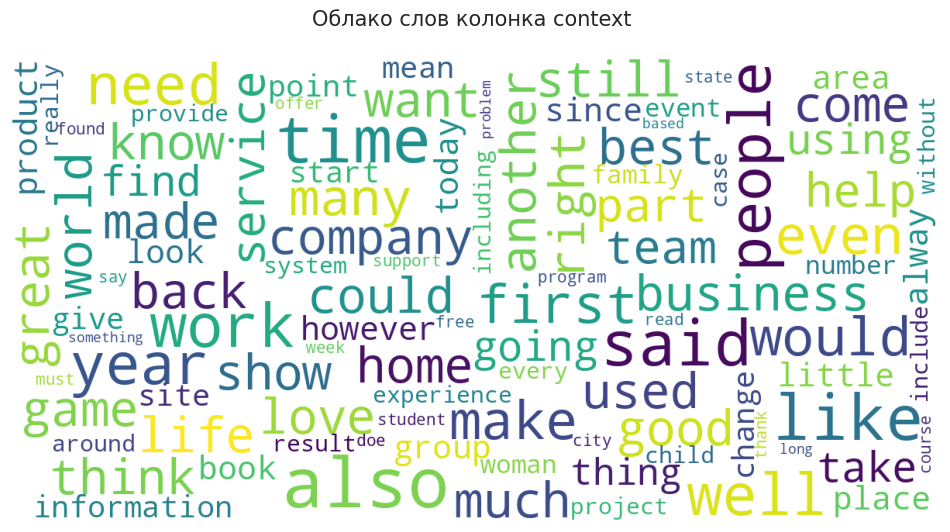

In [38]:
plot_wordcloud(df_clear['context'], 'context')

Выделяются слова: работа, бизнес, продукт, люди, компания, время, год, игра, команда, сервис, книга, помощь. Часто встреющиеся глаголы: нравится, думать, использовать, знать, искать.

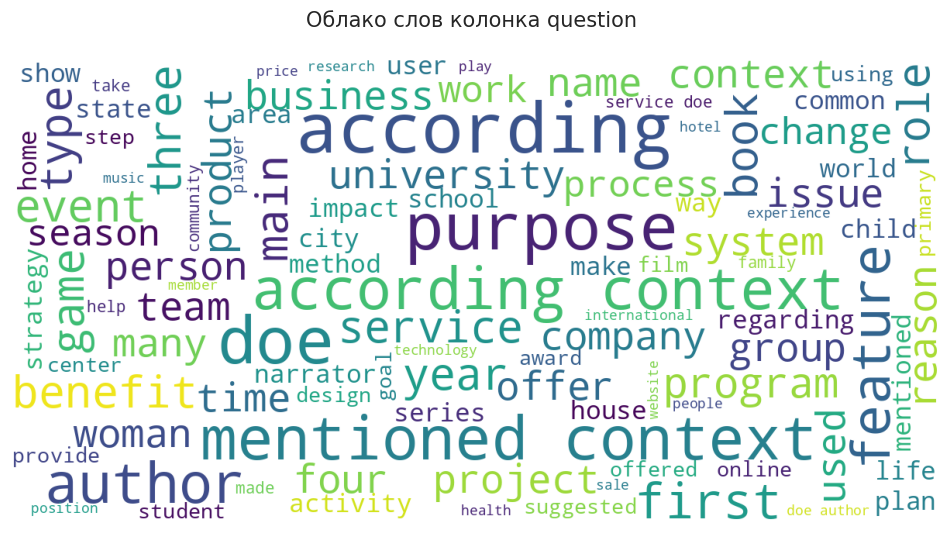

In [39]:
plot_wordcloud(df_clear['question'], 'question')

Привлекает внимание - цель, процесс, проблема, автор, упоминание, главный. Слово context, как было замечено ранее, много вопросов сформулировано с помощью этого слова, как указателя, где искать ответ.

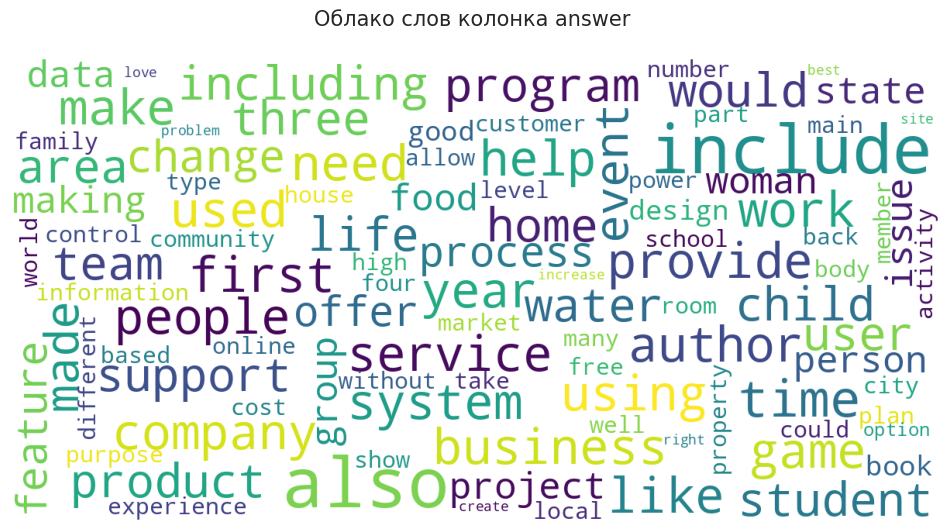

In [112]:
plot_wordcloud(df_clear['answer'], 'answer')

Частотные слова: продукт, бизнес, сервис, компания, игра, включать, помощь, команда, нравится, студент, книга. Видно, что по частотности слова пересекаются с контекстом.

Диаграммы подтверждают гипотезу о связности текстов в колонках, так как темы, с которыми связаны ключевые слова, в разных колонках повторяются.

#### TSNE

 t-SNE — метод уменьшения размерности, в данном случае, мы используем его для визуализации расстояний между словами, плотности различных секций слов

In [40]:
# Препроцессинг текста и построение единого корпуса текста контекста для TNSE

def clear_text(text):
    #  разбиение на предложения
    sentences = []
    for text_i in tqdm(text):
        for el in sent_tokenize(text_i):
            sentences.append(el)

    return [prep(sentence).split() for sentence in tqdm(sentences)]


In [41]:
# применение функции к колонке контекст
text_lemm = clear_text(df.context)

100%|██████████| 361104/361104 [00:29<00:00, 12140.01it/s]


Создание векторов с помощью  Word2Vec для дальнейшей визуализации

In [42]:
# инициализация модели
%time  model_w2v = Word2Vec(text_lemm, workers=4, vector_size=300, min_count=5, window=10)

CPU times: user 1min 44s, sys: 621 ms, total: 1min 45s
Wall time: 1min 3s


In [43]:
model_w2v.build_vocab(text_lemm) # построение словаря
model_w2v.train(text_lemm, total_examples=model_w2v.corpus_count, epochs=model_w2v.epochs)
vocab_len = len(model_w2v.wv) # длина словаря
vocab_len

33805

In [44]:
# вывод близких слов
model_w2v.wv.most_similar(positive=["think"], topn=5)

[('seem', 0.6055916547775269),
 ('anyway', 0.591835618019104),
 ('thinking', 0.5402727127075195),
 ('probably', 0.529559314250946),
 ('stupid', 0.5281670689582825)]

In [45]:
# проверка модели и словаря
print(model_w2v.wv.most_similar(positive=["bread", "cake"], negative=["sweet"], topn=1))
print(model_w2v.wv.most_similar("america", topn=3))
print(model_w2v.wv.doesnt_match("comedy thriller novel".split()))

[('cup', 0.6765493750572205)]
[('korea', 0.5914331674575806), ('american', 0.5597001314163208), ('dakota', 0.5201403498649597)]
novel


In [46]:
# для сбора частотности используем библиотеку  nltk.FreqDist
# иницализация
fd = FreqDist()

In [47]:
# подготовительные данные для tnse диаграммы
# определение частотности
top_words, top_only_words, top_words_count = [], [], []

# создание массива с 200 топ-слов
for text in text_lemm:
    fd.update(text)
for i in fd.most_common(200):
    # словарь с наиболее часто встречающимися словами (топ 200)
    top_words.append(i)
    top_words_count.append(i[1])
    # список топ-100 слов
    top_only_words.append(i[0])

In [51]:
# векторизация топ 200 слов
top_words_vec = model_w2v.wv[top_only_words]
# снижение размерности вектора слова
tsne = TSNE(n_components=2, random_state=0)
top_words_tsne = tsne.fit_transform(top_words_vec)

# https://docs.bokeh.org/en/latest/
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
output_notebook()

p = figure(title="T-SNE для топ-200", frame_height = 1000, frame_width = 1000)

source = ColumnDataSource(
    data=dict(
        x1=top_words_tsne[:,0],
        x2=top_words_tsne[:,1],
        names=top_only_words))

p.scatter(
    x="x1",
    y="x2",
    size=8,
    source=source)

labels = LabelSet(
    x="x1",
    y="x2",
    text="names",
    y_offset=6,
    text_font_size="8pt",
    text_color="#555555",
    source=source,
    text_align='right')

p.add_layout(labels)
show(p)

Альтернативный график с помощью  plotly.express

In [49]:
import plotly.express as px
fig = px.scatter(None, x=top_words_tsne[:,0], y=top_words_tsne[:,1],
labels={
"x": "x1",
"y": "x2",
},
opacity=1,
color=top_words,
hover_data=[top_only_words]
)

# Изменение цвета фона графика
fig.update_layout(dict(plot_bgcolor = 'white'))

# Обновление линий осей
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey',
zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey',
showline=True, linewidth=1, linecolor='black')

fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey',
zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey',
showline=True, linewidth=1, linecolor='black')

# Установка названия рисунка
fig.update_layout(title_text="t-SNE для топ-200")

# Обновление размера маркера
fig.update_traces(marker=dict(size=10))

In [50]:
# 3-d график близости слов
from sklearn.manifold import TSNE

tsne_3d = TSNE(n_components = 3, random_state = 0)
top_words_tsne_3d = tsne_3d.fit_transform(top_words_vec, )

fig = px.scatter_3d(
    top_words_tsne_3d, x=0, y=1, z=2,
    color = top_words, labels={'color': 'top_words'}
)
fig.update_traces(marker_size=8)
fig.update_layout(title_text="t-SNE для топ-200 слов")
fig.show()

Выводы: по диаграммам не выявлено отдельных обособленных скоплений, в основном слова находятся на небольшом расстоянии, хорошо выявлены близкие по смыслу и синонимы. Видно что есть скопления, связанные с временными характеристиками, такими как год, минута, час, день  и т.д. что-то с образованием - школа, студенты, университет. С конкретными персонами, с продажами и ценами, местоположением - мир, америка, с публикациями - комментарии, отчеты, медиа и т.д.


####Topic modeling

Попробуем  более глубоко понять на какие темы тексты в колонке контекст

In [124]:
# добавление нграмм

bigram_vectorizer = CountVectorizer(ngram_range=(2, 3),token_pattern=r'[A-Za-z]+', stop_words = STOPWORDS, min_df=10)
analyze = bigram_vectorizer.build_analyzer()
df['ngramm'] = df['context'].apply(lambda x: analyze(x))
df['ngramm'] = df['ngramm'].apply(lambda x: (', '.join(x)))

In [125]:
df.head(3)

,context,question,answer,length__context_word,length_contex_symbol,length__question_word,length_question_symbol,length__answer_word,length_answer_symbol,ngramm
0,Caption: Tasmanian berry grower Nic Hansen sho...,What is the Berry Export Summary 2028 and what...,The Berry Export Summary 2028 is a dedicated e...,563,3598,12,62,50,311,"caption tasmanian, tasmanian berry, berry grow..."
1,RWSN Collaborations Southern Africa Self-suppl...,What are some of the benefits reported from ha...,Benefits reported from having access to Self-s...,713,4661,14,87,48,325,"rwsn collaborations, collaborations southern, ..."
2,All Android applications categories Descriptio...,What are the unique features of the Coolands f...,The unique features of the Coolands for Twitte...,633,3844,11,61,61,406,"android applications, applications categories,..."


In [126]:
%pip install pyLDAvis
clear_output()
import pyLDAvis.gensim # библиотека для визуализации LDA

In [132]:
# Функция, которая разбивает данные на топики (num_topics = 10) по темам с помощью модели gensim.models.LdaMulticore
def get_lda_objects(text):

    corpus = preprocess(text)
    dic = gensim.corpora.Dictionary(corpus)
    bow_corpus = [dic.doc2bow(doc) for doc in corpus]
    lda_model =  gensim.models.LdaMulticore(bow_corpus,
                                    random_state = 42,
                                    num_topics = 10,
                                    id2word = dic,
                                    passes = 10,
                                    workers = 2)

    return lda_model, bow_corpus, dic
# визуализация топиков,pyLDAvis - пакет извлекает информацию из подобранной тематической модели LDA для интерактивной веб-визуализации
def plot_lda_vis(lda_model, bow_corpus, dic):
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dic, mds='tsne')
    return vis

In [133]:
# построим анализ контекста по столбцу с n-граммам
lda_model, bow_corpus, dic = get_lda_objects(df['ngramm'])

100%|██████████| 11997/11997 [03:33<00:00, 56.12it/s]


In [134]:
lda_model.show_topics()

[(0,
  '0.012*"student" + 0.010*"school" + 0.006*"university" + 0.005*"work" + 0.005*"year" + 0.005*"art" + 0.004*"program" + 0.004*"new" + 0.004*"education" + 0.004*"college"'),
 (1,
  '0.008*"game" + 0.007*"team" + 0.007*"year" + 0.006*"said" + 0.005*"first" + 0.005*"season" + 0.005*"one" + 0.005*"two" + 0.004*"crusher" + 0.004*"last"'),
 (2,
  '0.008*"food" + 0.005*"one" + 0.004*"make" + 0.004*"also" + 0.004*"body" + 0.004*"time" + 0.004*"like" + 0.003*"day" + 0.003*"may" + 0.003*"oil"'),
 (3,
  '0.012*"game" + 0.007*"casino" + 0.006*"free" + 0.004*"new" + 0.004*"one" + 0.004*"time" + 0.003*"get" + 0.003*"online" + 0.003*"play" + 0.003*"also"'),
 (4,
  '0.008*"like" + 0.008*"one" + 0.008*"time" + 0.007*"get" + 0.005*"make" + 0.005*"want" + 0.005*"would" + 0.004*"love" + 0.004*"know" + 0.004*"great"'),
 (5,
  '0.005*"use" + 0.005*"product" + 0.004*"system" + 0.004*"also" + 0.004*"new" + 0.004*"used" + 0.003*"window" + 0.003*"one" + 0.003*"price" + 0.003*"service"'),
 (6,
  '0.007*"se

In [135]:
plot_lda_vis(lda_model, bow_corpus, dic)

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
7      -17.438084   57.369438       1        1  14.451355
8      -86.023544   -2.201625       2        1  13.891237
4       73.087959   46.503567       3        1  12.722445
5        4.585808  -13.381381       4        1  11.112881
9       94.457512  -31.448626       5        1  10.947542
1     -107.470390   75.781326       6        1   9.812366
6      -59.714539  -78.617943       7        1   9.212241
0       46.677082  122.940163       8        1   7.493143
2       28.969316  -92.771355       9        1   6.802002
3      -41.818817  136.722672      10        1   3.554787, topic_info=         Term          Freq         Total Category  logprob  loglift
663      game  28473.000000  28473.000000  Default  30.0000  30.0000
2750  student  17697.000000  17697.000000  Default  29.0000  29.0000
2205   school  21709.000000  21709.000000  Default  28.0000  28.0000
72       food  16242.000000  16242.000000  Default  27.0000  27.0000
1960  company  27917.000000  27917.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
212      year   1577.269110  72904.042214  Topic10  -6.0615  -0.4966
211     world   1328.981710  26648.237158  Topic10  -6.2327   0.3386
938       day   1336.570278  50697.655415  Topic10  -6.2270  -0.2989
24       best   1202.214748  31137.674964  Topic10  -6.3330   0.0826
707      make   1196.660621  53872.058705  Topic10  -6.3376  -0.4702

[1035 rows x 6 columns], token_table=        Topic      Freq      Term
term                             
20815       2  0.915372  abortion
20815       5  0.005730  abortion
20815       7  0.075923  abortion
112071      1  0.988609    abraaj
2026        1  0.055111  academic
...       ...       ...       ...
53360       2  0.987888     zahid
52558       7  0.989172   zendesk
93893       4  0.994131    zimbra
96119       5  0.988021      zoey
4030        8  0.992150    zotero

[5168 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 9, 5, 6, 10, 2, 7, 1, 3, 4])

Площадь каждого круга представляет важность темы относительно корпуса  
Расстояние между центрами кругов указывает на сходство между темами
Гистограмма справа показывает 30 самых релевантных теме слов, по-другому их можно назвать ключевые слова. С помощью регулирования параметра лямбда можно изменять метрику релевантности. Темы не пересекаются и находятся на расстоянии между собой, что говорит о том, что можно выделить и большее количество тем, чем 10. Темы:

-  наиболее релевантными словами являются: one, like, love, people, book (условно говоря тема о предпочтениях людей).

- сервис, бизнес, работа, продукт, софт

- здоровье, медицина, закон, правильство, сервис, забота

- игры, команды, сезон, игроки

- машины, дизайн, модели

- отели, номера, свадьбы, казино

- школа, университет, семья, церковь

- еда, зелень, курица, яйца, блюда, рецепты

- музей, искусство, комьюнити, история, премия

- фильмы, музыка, forex, инвесторы, трейдинг, магазины


Самые многочисленные топики - 1, 2, 3 темы

In [136]:
# построим анализ контекста по столбцу с context очищенному от "шума"
lda_model, bow_corpus, dic = get_lda_objects(df_clear['context'])

100%|██████████| 11997/11997 [00:35<00:00, 339.75it/s]


In [137]:
plot_lda_vis(lda_model, bow_corpus, dic)

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
3     -17.083776 -17.250057       1        1  24.649475
1      -8.596234  74.552444       2        1  15.722466
9      12.436726  20.774776       3        1  14.448224
6      51.492367 -11.443501       4        1  12.215396
8     -70.036446  61.837910       5        1  11.690582
2      15.183801 -55.516590       6        1   5.382450
4     -77.852524  -2.558301       7        1   4.965011
5      48.287647  54.431320       8        1   3.801087
7     -50.580845 -53.882881       9        1   3.691542
0     -35.383907  27.418043      10        1   3.433767, topic_info=        Term         Freq         Total Category  logprob  loglift
70      food  3010.000000   3010.000000  Default  30.0000  30.0000
156     said  9607.000000   9607.000000  Default  29.0000  29.0000
632     game  5707.000000   5707.000000  Default  28.0000  28.0000
2412  health  2891.000000   2891.000000  Default  27.0000  27.0000
2094  school  4269.000000   4269.000000  Default  26.0000  26.0000
...      ...          ...           ...      ...      ...      ...
2169   power   250.277792   2584.271891  Topic10  -6.1796   1.0369
913     item   226.378706   1523.454485  Topic10  -6.2800   1.4650
88      high   256.434190   4653.510196  Topic10  -6.1553   0.4730
216     also   245.114032  12815.897486  Topic10  -6.2004  -0.5852
632     game   222.160940   5707.610971  Topic10  -6.2988   0.1254

[958 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
13569      1  0.016204      acid
13569      2  0.003241      acid
13569      4  0.003241      acid
13569      5  0.019444      acid
13569      6  0.823141      acid
...      ...       ...       ...
394        4  0.147718  zimbabwe
394        6  0.011363  zimbabwe
394        8  0.011363  zimbabwe
394        9  0.749952  zimbabwe
6439       8  0.968969  zucchini

[4490 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 10, 7, 9, 3, 5, 6, 8, 1])

По большей части темы получились похожие, что позволяет уже сделать выводы о чем наш основной столбец с контекстами, это:

- тексты о спорте,
- компьютерных играх,
- отдыхе в отелях (пляж/виды) + семейных мероприятиях/праздниках,
- об образовании,
- об искусстве (музеях, кинематографе),
- о здоровье и зравоохранении
- рецепты/еда, диета
- компьютерная индустрия
- компании, бизнес
- торговля, магазины, покупки, электронная торговля

In [138]:
# построим анализ контекста по столбцу с question
lda_model, bow_corpus, dic = get_lda_objects(df_clear['question'])
plot_lda_vis(lda_model, bow_corpus, dic)

100%|██████████| 11997/11997 [00:01<00:00, 7020.62it/s]


PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
1     -35.327263  -8.647415       1        1  12.558071
0      32.345966  20.346407       2        1  11.477687
4      34.448132  -8.443151       3        1  11.262549
6     -15.970001  39.573776       4        1  10.318103
3      13.056725 -27.877834       5        1   9.779805
8     -12.539724  10.238877       6        1   9.450891
9       8.451402  30.698158       7        1   9.415611
5     -37.290199  20.160837       8        1   8.944133
7     -11.403981 -19.019310       9        1   8.849185
2       9.631166   1.440720      10        1   7.943964, topic_info=          Term        Freq       Total Category  logprob  loglift
90      author  467.000000  467.000000  Default  30.0000  30.0000
42     context  887.000000  887.000000  Default  29.0000  29.0000
53   mentioned  415.000000  415.000000  Default  28.0000  28.0000
353    service  270.000000  270.000000  Default  27.0000  27.0000
664    offered  128.000000  128.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
922       many   14.940355  106.151538  Topic10  -6.0103   0.5720
12     feature   15.903806  327.985664  Topic10  -5.9478  -0.4937
49      reason   14.857401  117.990470  Topic10  -6.0158   0.4607
711       work   14.532731  100.948145  Topic10  -6.0379   0.5946
283      three   14.725452  180.152694  Topic10  -6.0247   0.0285

[765 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
8598     10  0.883187  abortion
6441      1  0.889988  academic
6441      9  0.063571  academic
1757      4  0.134548  accepted
1757      8  0.807290  accepted
...     ...       ...       ...
140       4  0.365137      year
140       6  0.046946      year
140       8  0.010432      year
140       9  0.005216      year
140      10  0.073027      year

[1914 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 5, 7, 4, 9, 10, 6, 8, 3])

По темам вопросов видим, что ключевыми словами самой многочисленной темы является:

авторы/книги/школы/ингридиенты/компании/цели/год(как дата/веб-сайты/города

персонажи/игры/выгода/предложение/награда

игроки/спорт/счет

упоминаются соцсети/города

есть храктерные для вопросов слова, такие как согласно/цели/роли/названия

В целом можно сделать вывод, что вопросы довольно связаны с темами контекста

In [139]:
# построим анализ контекста по столбцу с answer
lda_model, bow_corpus, dic = get_lda_objects(df_clear['answer'])
plot_lda_vis(lda_model, bow_corpus, dic)

100%|██████████| 11997/11997 [00:03<00:00, 3599.22it/s]


PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
7     -67.709915  33.706257       1        1  20.918107
0      -8.904402 -23.634474       2        1  12.128803
2      56.312542  -4.058400       3        1  10.930566
1      29.554890 -47.534058       4        1  10.913284
5     -60.283100 -21.650702       5        1   9.920977
6     -15.441483  59.529858       6        1   8.461934
8     -26.826521 -63.713593       7        1   7.866658
4      14.763681  12.322543       8        1   6.622395
9      36.007023  51.157658       9        1   6.400613
3     -28.225203  14.932197      10        1   5.836665, topic_info=          Term        Freq        Total Category  logprob  loglift
258     author  578.000000   578.000000  Default  30.0000  30.0000
1200      room  278.000000   278.000000  Default  29.0000  29.0000
314    student  290.000000   290.000000  Default  28.0000  28.0000
622     school  314.000000   314.000000  Default  27.0000  27.0000
632   customer  276.000000   276.000000  Default  26.0000  26.0000
...        ...         ...          ...      ...      ...      ...
1541    needed   27.661650   129.757680  Topic10  -6.2874   1.2954
262       also   33.734990  1829.291340  Topic10  -6.0889  -1.1521
188       love   25.869607   186.782819  Topic10  -6.3543   0.8641
301      woman   26.180770   270.797438  Topic10  -6.3424   0.5047
258     author   25.127135   578.560031  Topic10  -6.3835  -0.2956

[811 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
921        1  0.505915  ability
921        2  0.068705  ability
921        3  0.024983  ability
921        4  0.068705  ability
921        5  0.074950  ability
...      ...       ...      ...
8329       2  0.265800  zealand
8329       7  0.620201  zealand
8329       9  0.088600  zealand
13887      7  0.768323   zillow
7671       5  0.828342   zipper

[2748 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 1, 3, 2, 6, 7, 9, 5, 10, 4])

По ответам выделены темы, содержащие ключевые слова

сервисы/информация/пользователи/данные/студенты/бизнес/работа/цели/саппорт/дизайн/видео

дома/цена/уровень/риски/качество/количество/рейтинг/магазины

еда/перец/сахар/курица и т.д. связанное с рецептами

женщины/вечеринки/рестораны/кухня/гости

города/национальности/население
и т.д.

При более внимательном рассмотрении не было обнаружено тем, которые не освещены в контексте. Можно утвердиться в предположении о связности текстов.

#### Parts of speech tagging

Анализ на части речи, использование их в текстах, распределение, топ частей речи в текстах. Для выявления частей речи используем nltk модель averaged_perceptron_tagger (модель обучена на основе персептрона). Анализ проводим по очищенному нормализованному тексту без пунктуации и посторонних символов.


* Noun (NN) - Существительное
* NNS - существительное в множественном числе
* Verb (VB) - Глагол
* Adjective (JJ) - Прилагательное
* Adverb  (RB) - Наречие
* Preposition (IN)- Предлог
* Conjunction (CC) - Союз
* Pronoun (PRP) - Местоимение
* Interjection (INT)  - Междометие
* NNP означает существительное собственное
* DT - артикли
* CD - дата

In [6]:
# функция выделяет части речи
def pos(text):
        pos = nltk.pos_tag(word_tokenize(text))
        pos = list(map(list,zip(*pos)))[1]
        return pos

def filter_pos(text, part_of_speach='NN'):
    # функция вподсчитывает часть речи
        pos_type = []
        pos = nltk.pos_tag(word_tokenize(text))
        for word,tag in pos:
            if tag == part_of_speach:
                pos_type.append(word)
        return pos_type

def plot_pos(text, part_of_speach='NN'):

    plt.figure(figsize = (15, 7)).suptitle('Наиболее часто встречающиеся части речи', fontsize=10)
    tags = tqdm(text.apply(lambda x : pos(x)))
    tags = [x for l in tqdm(tags) for x in l]
    counter = Counter(tags)
    x,y =list(map(list,zip(*counter.most_common(10))))
    plt.subplot(1, 2, 1)
    sns.barplot(x = y,y = x).set_title('Распределение по частям речи')

    words=text.apply(lambda x : filter_pos(x))
    words=[x for l in words for x in l]
    counter=Counter(words)
    x,y=list(map(list,zip(*counter.most_common(10))))
    plt.subplot(1, 2, 2)
    sns.barplot(x = y,y = x, hue = y).set_title(part_of_speach)


100%|██████████| 11997/11997 [00:00<00:00, 45753.63it/s]


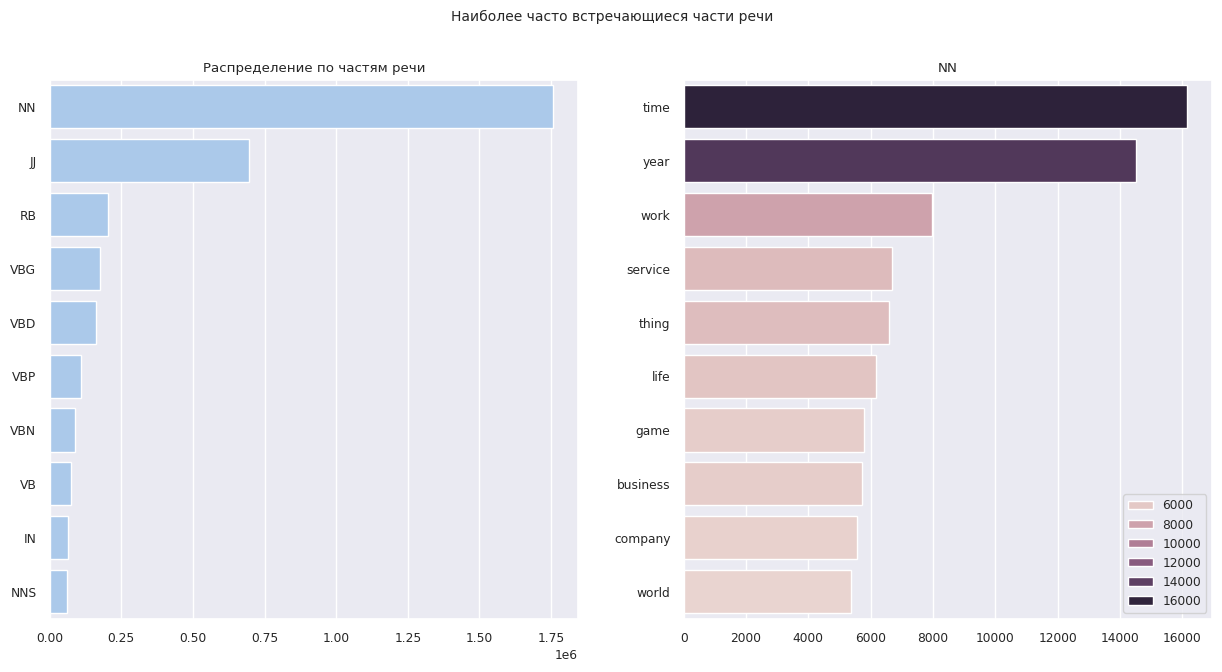

In [142]:
plot_pos(df_clear['context'])

Ожидаемо в тексте большинство существительных, в контексте - это слова, связанные с датой, работой, играми, вещами, жизнью

100%|██████████| 11997/11997 [00:00<00:00, 520265.77it/s]


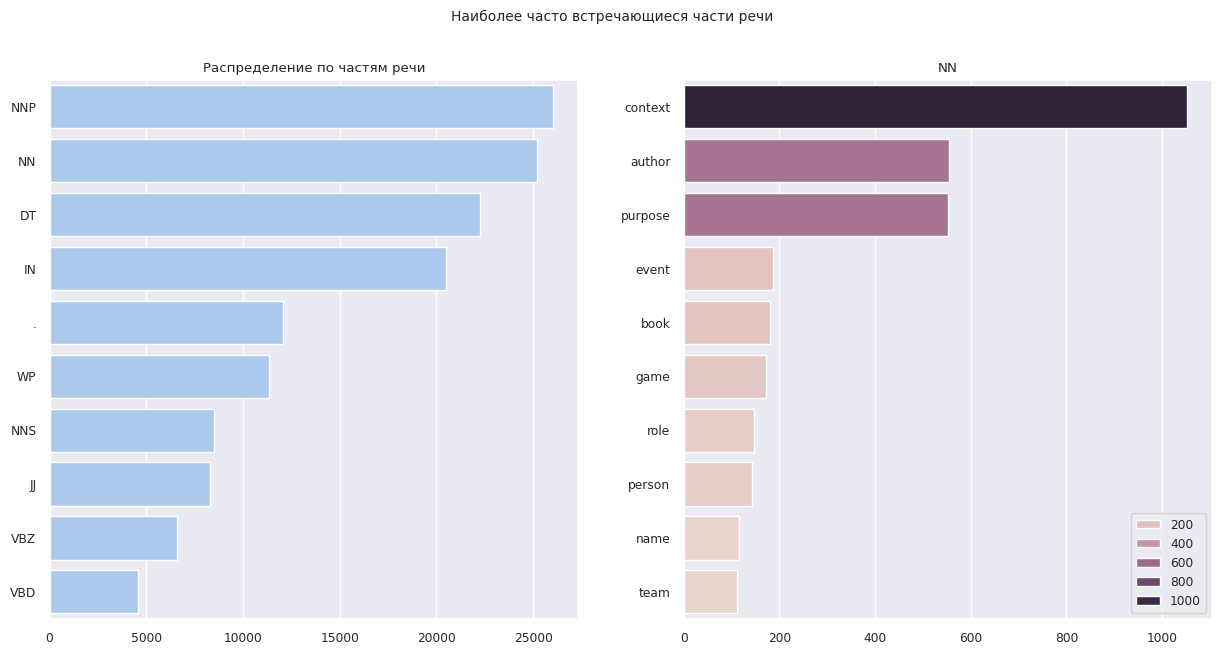

In [143]:
plot_pos(df['question'])

В вопросах, часто упоминается само слово context, то есть вопрос часто отсылает к конкретному столбцу, где искать ответ. Также вопросы связаны с такими словами как автор, цели, события, книги, игры, роли.

100%|██████████| 11997/11997 [00:00<00:00, 326444.05it/s]


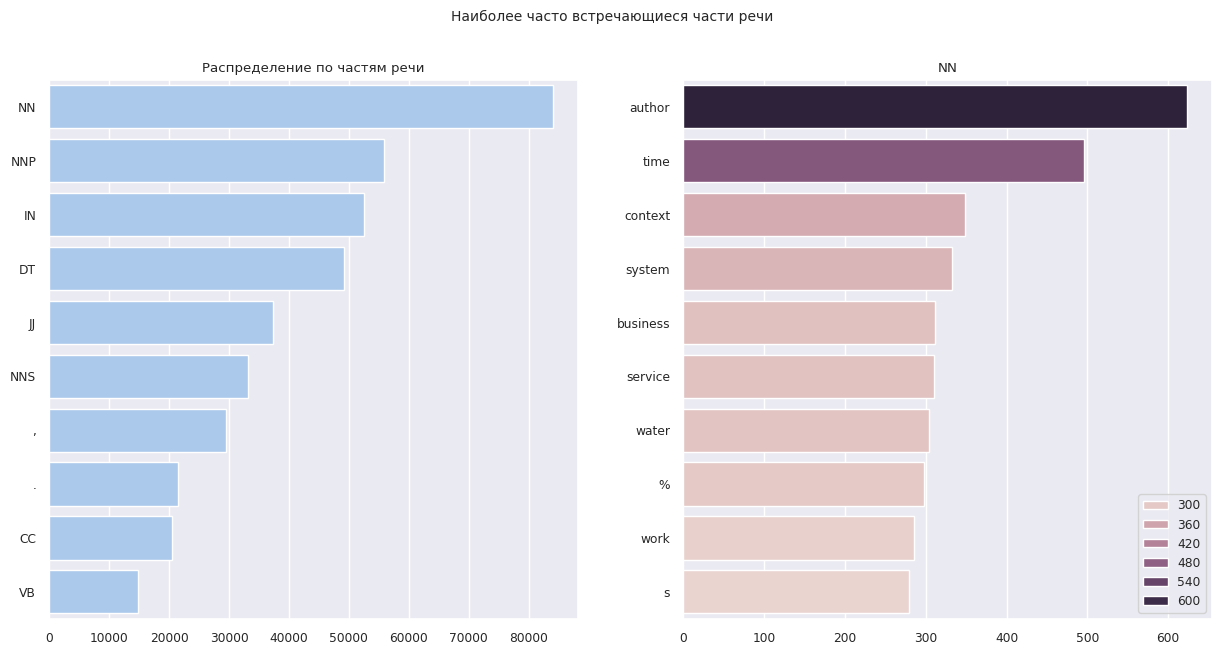

In [144]:
plot_pos(df['answer'])

Большинство ответов базируется на существительных автор, время, опять же контекст, система, бизнес, сервис, вода. Так как график строится на колонке без очистки текста то в топ попал знак % (в ответах этот символов может иметь смысловое значение, так как в текстах есть информация по цифрам).

#### Named entity recognition

Для извлечени именованных сущностей используется библиотека spacy, модель en_core_web_sm (English pipeline optimized for CPU. Components: tok2vec, tagger, parser, senter, ner, attribute_ruler, lemmatizer / written text (blogs, news, comments)) - модель обучена на английском языке на письменном веб-тексте (блоги, новости, комментарии), включает в себя слова, синтаксис и сущности.
[Модели](https://spacy.io/models/en)

* PERSON - People, including fictional.
* NORP - Nationalities or religious or political groups.
* FAC - Buildings, airports, highways, bridges, etc.
* ORG - Companies, agencies, institutions, etc.
* GPE - Countries, cities, states.
* LOC - Non-GPE locations, mountain ranges, bodies of water.
* PRODUCT - Objects, vehicles, foods, etc. (Not services.)
* EVENT - Named hurricanes, battles, wars, sports events, etc.
* WORK_OF_ART - Titles of books, songs, etc.
* LAW - Named documents made into laws.
* LANGUAGE - Any named language.
* DATE - Absolute or relative dates or periods.
TIME - Times smaller than a day.
* PERCENT - Percentage, including "⅒".
* MONEY - Monetary values, including unit.
* QUANTITY - Measurements, as of weight or distance.
* ORDINAL - "first", "second", etc.
* CARDINAL - Numerals that do not fall under another type.

In [145]:
import spacy
nlp = spacy.load("en_core_web_sm")


def get_ner(text):
    doc=nlp(text)
    return [X.label_ for X in doc.ents]

def get_ner_person(text,ent):
    doc = nlp(text)
    return [X.text for X in doc.ents if X.label_ == ent]

def plot_named_entity(text, entity="PERSON"):

    plt.figure(figsize = (15, 7)).suptitle('Наиболее часто встречающиеся сущности', fontsize=10)


    ent=text.apply(lambda x : get_ner(x))
    ent=[x for sub in ent for x in sub]
    counter=Counter(ent)
    count=counter.most_common()

    x,y=map(list,zip(*count))
    plt.subplot(1, 2, 1)

    sns.barplot(x=y,y=x).set_title('Распределение по именованным сущностям')


    entity_filtered=text.apply(lambda x: get_ner_person(x,entity))
    entity_filtered=[i for x in entity_filtered for i in x]

    counter=Counter(entity_filtered)
    x,y=map(list,zip(*counter.most_common(10)))
    plt.subplot(1, 2, 2)
    sns.barplot(x = y,y = x, hue = y).set_title(entity)

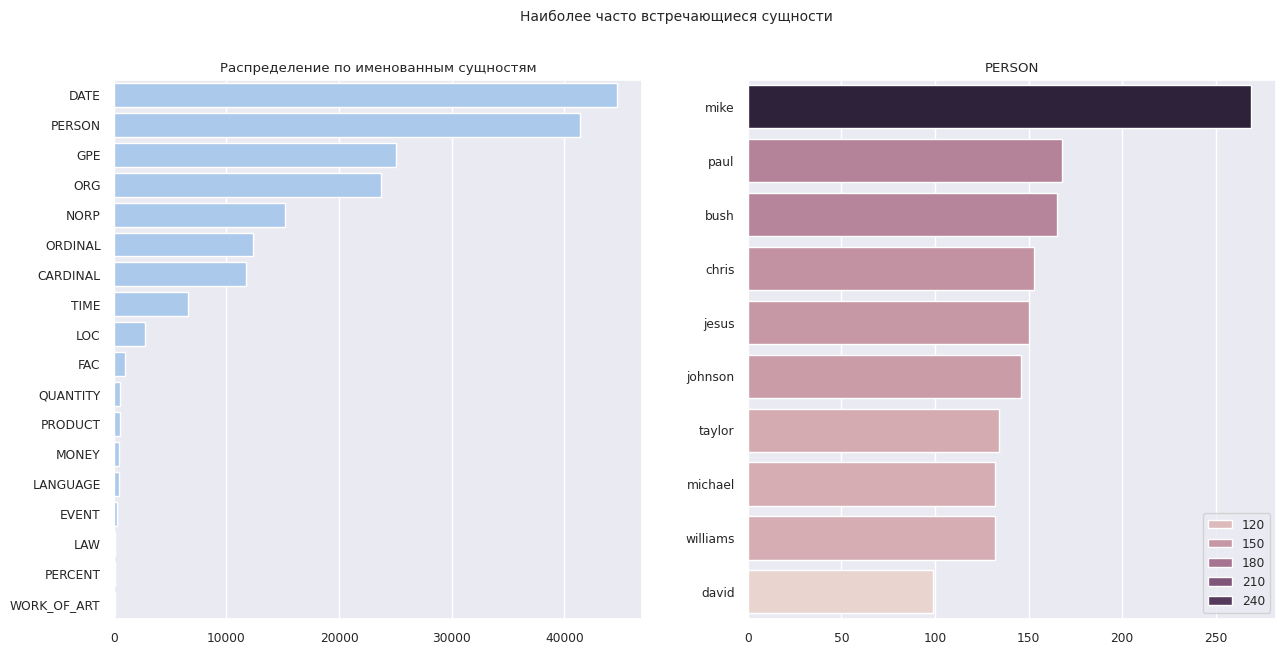

In [146]:
plot_named_entity(df_clear['context'])

Эти графики также дают нам представление о сути имеющихся текстов, видно, что в текстах речь о персонах/людях, о датах, числительных, организациях, локациях, национальностях, политических группах,  времени, о водоемах, ландшафте.
При рассмотрении топовой категории - персоны: видим, что речь идет о конкретных именах.

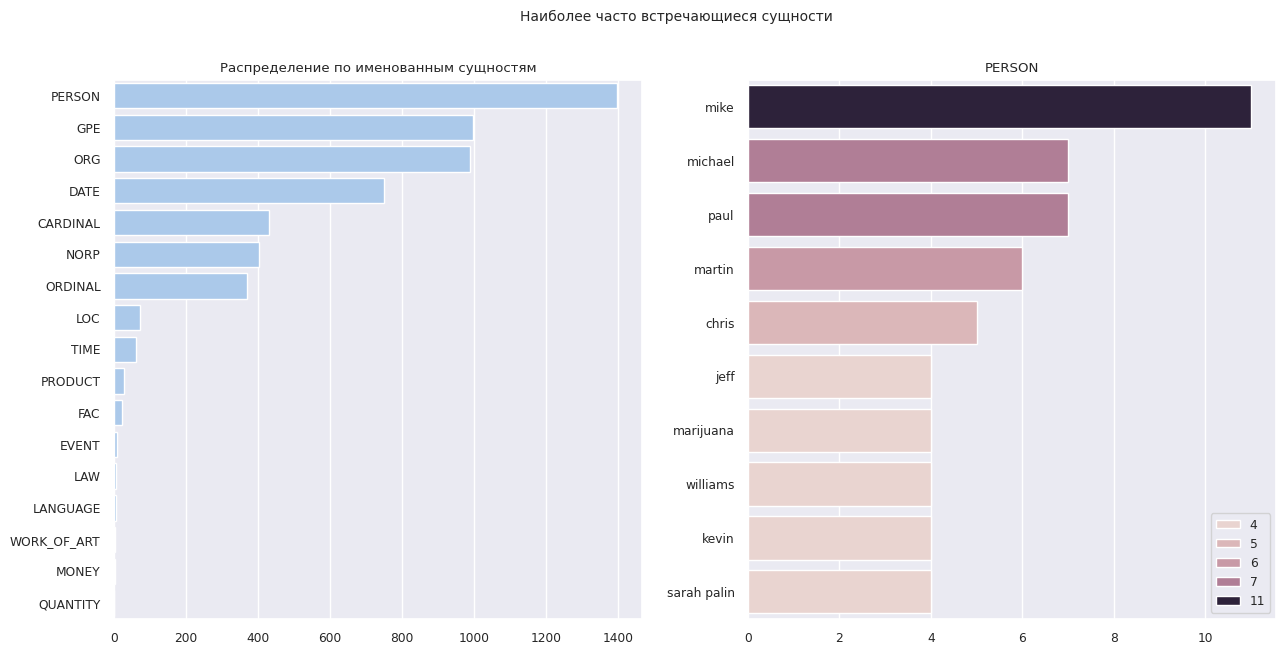

In [147]:
plot_named_entity(df_clear['question'])

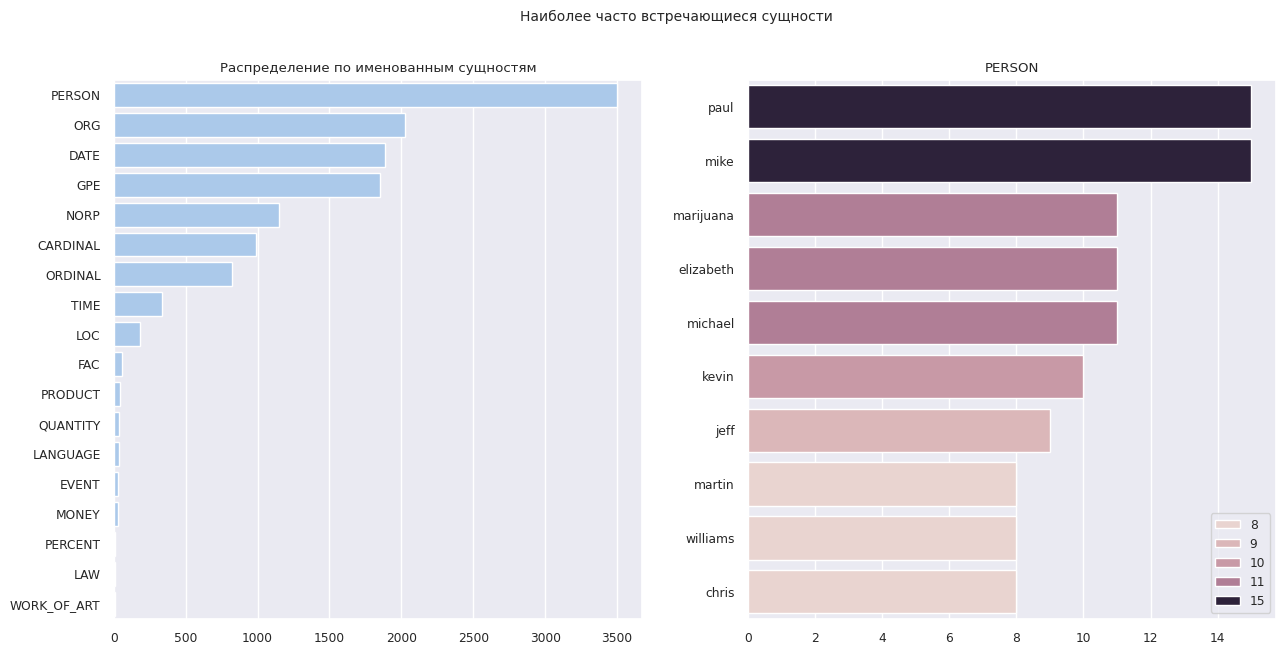

In [148]:
plot_named_entity(df_clear['answer'])

Графики по колонкам с вопросами и ответами показывают аналогичное распределение.

**Выводы:**

Данные в датасете консистентны, прослеживается связь вопрос - контекст - ответ.

Содкржание текстов о жизни, о насущных проблематиках, которые часто обсуждаются в разных сферах:  
- отдых/путешествия/времяпрепровождение  
- образование  
- книги/фильмы  
- рецепты  
- события в мире искусства  
- премии награждения  
- компьютерная индустрия и компьютерные игры  


Также видно, что вопросы какаются конкретных личностей, определенных мест или локаций, актуальных болезней. Данные подойдут для вопросно - ответной системы.

Для применения датасета в модель, нужно определиться со стратегией препроцессинга, сформировав свой список стоп-слов, например, смущает частоттное слово "the context" в колонке с вопросами. Нужно принять решение, что делать с дубликатами в колонке с вопросами.




